# Exploring KS2 Data

In [1]:
# imports
import pandas as pd
import scipy.stats
import numpy as np
import matplotlib as plt

%matplotlib inline

## Import the LEA data

In [4]:
leas_df = pd.read_csv('data/la_and_region_codes_meta.csv')
leas_df.head()

,LEA,LA Name,REGION,REGION NAME
0,841,Darlington,1,North East A
1,840,County Durham,1,North East A
2,805,Hartlepool,1,North East A
3,806,Middlesbrough,1,North East A
4,807,Redcar and Cleveland,1,North East A


## Import the KS2 data

Most of the field names are given in the `ks2_meta` file, so we'll use that to keep track of the types of various columns. 

In [5]:
ks2cols = pd.read_csv('data/ks2_meta.csv')
ks2cols['Field Name'] = ks2cols['Field Name'].apply(lambda r: r.strip(),)
ks2cols.head()

,Column,Field Name,Label/Description
0,1,RECTYPE,Record type (1=mainstream school; 2=special sc...
1,2,ALPHAIND,Alphabetic index
2,3,LEA,Local authority number
3,4,ESTAB,Establishment number
4,5,URN,School unique reference number


Some columns contain integers, but _**pandas**_ will treat any numeric column with `na` values as `float64`, due to NumPy's number type hierarchy. 

In [6]:
int_cols = [c for c in ks2cols['Field Name'] 
            if c.startswith('T')
            if c not in ['TOWN', 'TELNUM', 'TKS1AVERAGE']]
int_cols += ['RECTYPE', 'ALPHAIND', 'LEA', 'ESTAB', 'URN', 'URN_AC', 'ICLOSE']
int_cols += ['READ_AVERAGE', 'GPS_AVERAGE', 'MAT_AVERAGE']

We'll convert percentages to floating point numbers on import, note that we need to handle the case of `SUPP` and `NEW` in the data.

In [18]:
def p2f(x):
    if x.strip('%').isdigit():
        return float(x.strip('%'))/100
    elif x in ['SUPP', 'NEW', 'LOWCOV', 'NA', '']:
        return 0.0
    else:
        return x

In [19]:
percent_cols = [f for f in ks2cols['Field Name'] if f.startswith('P')]
percent_cols += ['WRITCOV', 'MATCOV', 'READCOV'] 
percent_cols += ['PTMAT_HIGH', 'PTREAD_HIGH', 'PSENELSAPK', 'PSENELK', 'PTGPS_HIGH']
percent_converters = {c: p2f for c in percent_cols}

In [20]:
ks2_df = pd.read_csv('data/england_ks2final.csv', 
                   na_values=['SUPP', 'NEW', 'LOWCOV', 'NA', ''],
                   converters=percent_converters)

Drop the summary rows, keeping just the rows for mainstream and special schools.

In [21]:
ks2_df = ks2_df[(ks2_df['RECTYPE'] == 1) | (ks2_df['RECTYPE'] == 2)]

Convert everything to numbers, if possible.

In [22]:
ks2_df = ks2_df.apply(pd.to_numeric, errors='ignore')

Merge the LEA data into the school data

In [23]:
ks2_df = pd.merge(ks2_df, leas_df, on=['LEA'])
ks2_df.head().T

,0,1,2,3,4
RECTYPE,1,1,1,1,1
ALPHAIND,53372,11156,11160,11256,16366
LEA,201,202,202,202,202
ESTAB,3614,3323,3327,2842,2184
URN,100000,100028,100029,130342,100013
SCHNAME,Sir John Cass's Foundation Primary School,"Christ Church Primary School, Hampstead",Christ Church School,Christopher Hatton Primary School,Edith Neville Primary School
ADDRESS1,St James's Passage,Christ Church Hill,Redhill Street,38 Laystall Street,174 Ossulston Street
ADDRESS2,Duke's Place,NaN,Camden,NaN,NaN
ADDRESS3,NaN,NaN,NaN,NaN,NaN
TOWN,London,London,London,London,London


## Format data in dataframe

In [24]:
# relevant columns (based on https://www.compare-school-performance.service.gov.uk/compare-schools):
#
# SCHNAME         : School Name
# NFTYPE          : School type
# PTRWM_EXP       : % of pupils meeting expected standard
# READPROG        : Reading
# WRITPROG        : Writing
# MATPROG         : Maths
# PTRWM_HIGH      : % of pupils achieving at a higher standard
# READ_AVERAGE    : Average score in reading
# MAT_AVERAGE     : Average score in maths

# other potentially relevant columns (for analysis):
#
# TOTPUPS         : Total number of pupils
# PTEALGRP1       : % of pupils with English as first language
# PTREAD_HIGH     : % of pupils achieving a high score in reading
# PTGPS_HIGH      : % of pupils achieving a high score in grammar, punctuation and spelling
# PTMAT_HIGH      : % of pupils achieving a high score in maths
# PTFSM6CLA1A     : % of key stage 2 disadvantaged pupils

# select only relevant columns in dataframe
ks2_df_short = ks2_df[['SCHNAME',
                       'NFTYPE',
                       'PTRWM_EXP',
                       'READPROG',
                       'WRITPROG',
                       'MATPROG',
                       'PTRWM_HIGH',
                       'READ_AVERAGE',
                       'MAT_AVERAGE',
                       'TOTPUPS',
                       'PTEALGRP1',
                       'PTREAD_HIGH',
                       'PTGPS_HIGH',
                       'PTMAT_HIGH',
                       'PTFSM6CLA1A']]

# rename columns in dataframe for clarity
ks2_df_short.columns = ['School name',
                        'School type',
                        '% of pupils meeting expected standard',
                        'Reading',
                        'Writing',
                        'Maths',
                        '% of pupils achieving at a higher standard',
                        'Average score in reading',
                        'Average score in maths',
                        'Total number of pupils',
                        '% of pupils with English as first language',
                        '% of pupils achieving a high score in reading',
                        '% of pupils achieving a high score in writing',
                        '% of pupils achieving a high score in maths',
                        '% of key stage 2 disadvantaged pupils']

# drop NaNs at this point
ks2_df_short = ks2_df_short.dropna()

# check
ks2_df_short.head()

,School name,School type,% of pupils meeting expected standard,Reading,Writing,Maths,% of pupils achieving at a higher standard,Average score in reading,Average score in maths,Total number of pupils,% of pupils with English as first language,% of pupils achieving a high score in reading,% of pupils achieving a high score in writing,% of pupils achieving a high score in maths,% of key stage 2 disadvantaged pupils
0,Sir John Cass's Foundation Primary School,VA,0.89,2.7,2.2,3.0,0.07,106.0,106.0,250.0,0.36,0.18,0.18,0.18,0.43
1,"Christ Church Primary School, Hampstead",VA,0.81,2.6,4.0,3.5,0.24,106.0,108.0,181.0,0.33,0.48,0.43,0.43,0.05
2,Christ Church School,VA,0.43,2.3,1.4,0.3,0.04,102.0,101.0,229.0,0.46,0.14,0.25,0.14,0.61
3,Christopher Hatton Primary School,CY,0.79,3.4,2.2,2.3,0.07,106.0,106.0,233.0,0.39,0.25,0.39,0.21,0.43
4,Edith Neville Primary School,CY,0.62,2.0,1.4,6.0,0.07,102.0,107.0,221.0,0.00,0.17,0.34,0.31,0.69


In [25]:
# additonal selection

# select only schools with some students
ks2_df_short = ks2_df_short[ks2_df_short['Total number of pupils'] > 0.0]

# check
ks2_df_short.head()

,School name,School type,% of pupils meeting expected standard,Reading,Writing,Maths,% of pupils achieving at a higher standard,Average score in reading,Average score in maths,Total number of pupils,% of pupils with English as first language,% of pupils achieving a high score in reading,% of pupils achieving a high score in writing,% of pupils achieving a high score in maths,% of key stage 2 disadvantaged pupils
0,Sir John Cass's Foundation Primary School,VA,0.89,2.7,2.2,3.0,0.07,106.0,106.0,250.0,0.36,0.18,0.18,0.18,0.43
1,"Christ Church Primary School, Hampstead",VA,0.81,2.6,4.0,3.5,0.24,106.0,108.0,181.0,0.33,0.48,0.43,0.43,0.05
2,Christ Church School,VA,0.43,2.3,1.4,0.3,0.04,102.0,101.0,229.0,0.46,0.14,0.25,0.14,0.61
3,Christopher Hatton Primary School,CY,0.79,3.4,2.2,2.3,0.07,106.0,106.0,233.0,0.39,0.25,0.39,0.21,0.43
4,Edith Neville Primary School,CY,0.62,2.0,1.4,6.0,0.07,102.0,107.0,221.0,0.00,0.17,0.34,0.31,0.69


## Is English as a first language important for performance?

In [26]:
# create a new dataframe for language and select only relevant columns
df_language = ks2_df_short[['School name',
                            '% of pupils with English as first language',
                            '% of pupils meeting expected standard',
                            '% of pupils achieving at a higher standard']]

# select only schools with some students achieving at a higher standard
df_language = df_language[df_language['% of pupils achieving at a higher standard'] > 0.0]

# select only schools with some students meeting expected standard
df_language = df_language[df_language['% of pupils meeting expected standard'] > 0.0]

# sort
df_language = df_language.sort_values(by=['% of pupils with English as first language'], ascending=True)

# check
df_language.head()

,School name,% of pupils with English as first language,% of pupils meeting expected standard,% of pupils achieving at a higher standard
3065,Pikes Lane Primary School,0.0,0.65,0.07
521,Kobi Nazrul Primary School,0.0,0.72,0.03
518,Harry Gosling Primary School,0.0,0.61,0.09
3411,Westwood Academy,0.0,0.68,0.04
4,Edith Neville Primary School,0.0,0.62,0.07


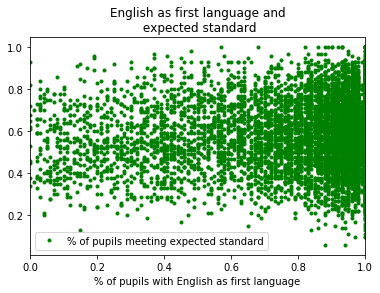

In [27]:
# expected standard
x = '% of pupils with English as first language'
y = '% of pupils meeting expected standard'

# plot schools as green dots
df_language.plot(x=x, y=y, style='g.', title='English as first language and\n expected standard')

As seen in the plot above, there is no apparent correlation between 'English as first language' and 'expected standard', whereas schools closer to 100%, or 1.0, English as first language are overrepresented and more concentrated.

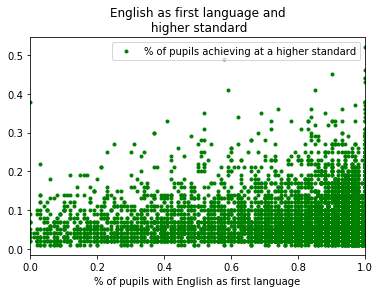

In [28]:
# higher standard
x = '% of pupils with English as first language'
y = '% of pupils achieving at a higher standard'

# plot schools as green dots
df_language.plot(x=x, y=y, style='g.', title='English as first language and\n higher standard')

As seen in the plot above, there seem to be some correlation between 'English as first language' and 'higher standard', whereas schools closer to 100%, or 1.0, English as first language also have a higher percentage of pupils achieving at a higher standard.

In [29]:
# pearson test: whereas correlation coefficient can range from -1 to +1
scipy.stats.pearsonr(df_language[x], df_language[y])[0]

0.090513478531071431

## Is total number of pupils important for performance?

In [30]:
# create a new dataframe for pupils and select only relevant columns
df_pupils = ks2_df_short[['School name',
                          'Total number of pupils',
                          '% of pupils meeting expected standard',
                          '% of pupils achieving at a higher standard']]

# select only schools with some students achieving at a higher standard
df_pupils = df_pupils[df_pupils['% of pupils achieving at a higher standard'] > 0.0]

# select only schools with some students meeting expected standard
df_pupils = df_pupils[df_pupils['% of pupils meeting expected standard'] > 0.0]

# sort
df_pupils = df_pupils.sort_values(by=['Total number of pupils'], ascending=True)

# check
df_pupils.head()

,School name,Total number of pupils,% of pupils meeting expected standard,% of pupils achieving at a higher standard
13068,Greystoke School,31.0,1.00,0.29
11845,Yealand Church of England Primary School,32.0,0.14,0.14
13077,Heversham St Peter's CofE Primary School,32.0,1.00,0.29
6238,Kirkby Fleetham Church of England Primary School,33.0,0.50,0.13
6316,St Hedda's Roman Catholic Primary School,34.0,0.43,0.14


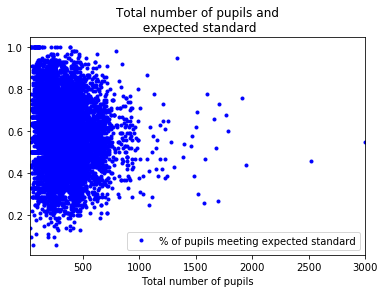

In [31]:
# expected standard
x = 'Total number of pupils'
y = '% of pupils meeting expected standard'

# plot schools as blue dots
df_pupils.plot(x=x, y=y, style='b.', title='Total number of pupils and\n expected standard')

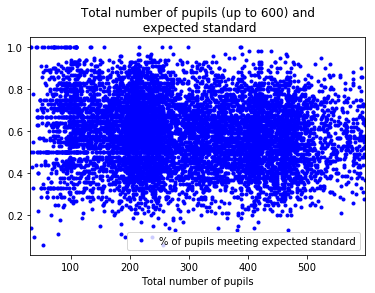

In [32]:
# select only schools with less than 600 pupils
df_pupils_alternative = df_pupils[df_pupils['Total number of pupils'] < 600]

# plot schools as blue dots
df_pupils_alternative.plot(x=x, y=y, style='b.', title='Total number of pupils (up to 600) and\n expected standard')

As seen in the plots above, there is no apparent correlation between 'Total number of pupils' and 'expected standard, but schools closer to 100%, or 1.0, also seem to have fewer pupils.

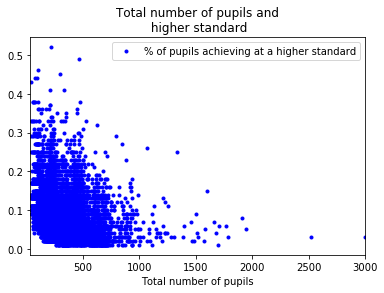

In [33]:
# higher standard
x = 'Total number of pupils'
y = '% of pupils achieving at a higher standard'

# plot schools as blue dots
df_pupils.plot(x=x, y=y, style='b.', title='Total number of pupils and\n higher standard')

As seen in the plot above, there seem to be some correlation between 'Total number of pupils' and 'higher standard', whereas schools with higher percentage of pupils achieving at a higher standard also has fewer total number of pupils.

In [34]:
# pearson test: whereas correlation coefficient can range from -1 to +1
scipy.stats.pearsonr(df_pupils[x], df_pupils[y])[0]

-0.216579406909373

## Is high scores in maths important for performance?

In [35]:
# create a new dataframe for pupils and select only relevant columns
df_maths = ks2_df_short[['School name',
                       '% of pupils achieving a high score in maths',
                       '% of pupils meeting expected standard',
                       '% of pupils achieving at a higher standard']]

# select only schools with some students achieving at a higher standard
df_maths = df_maths[df_maths['% of pupils achieving at a higher standard'] > 0.0]

# select only schools with some students meeting expected standard
df_maths = df_maths[df_maths['% of pupils meeting expected standard'] > 0.0]

# sort
df_maths = df_maths.sort_values(by=['% of pupils achieving a high score in maths'], ascending=True)

# check
df_maths.head()

,School name,% of pupils achieving a high score in maths,% of pupils meeting expected standard,% of pupils achieving at a higher standard
4028,Morley Place Junior School,0.01,0.32,0.01
10630,The Gateway Primary Free School,0.01,0.26,0.01
14243,Angel Road Junior School,0.01,0.37,0.01
4997,Airedale Junior School,0.01,0.48,0.01
16094,"Bishop Tufnell CofE Junior School, Felpham",0.01,0.32,0.01


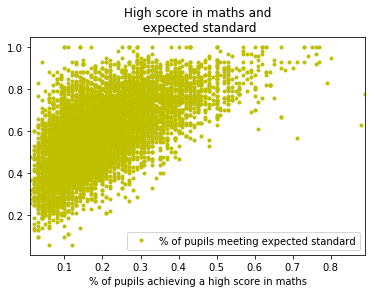

In [36]:
# expected standard
x = '% of pupils achieving a high score in maths'
y = '% of pupils meeting expected standard'

# plot schools as yellow dots
df_maths.plot(x=x, y=y, style='y.', title='High score in maths and\n expected standard')

As seen in the plot above, there seem to be some correlation between 'High score in maths' and 'expected standard', whereas schools with more pupils with high score in maths also have more pupils meeting the expected standard.

In [37]:
# pearson test: whereas correlation coefficient can range from -1 to +1
scipy.stats.pearsonr(df_maths[x], df_maths[y])[0]

0.62469289822234142

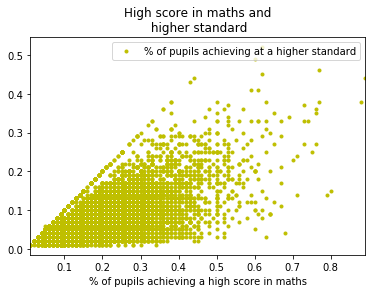

In [38]:
# higher standard
x = '% of pupils achieving a high score in maths'
y = '% of pupils achieving at a higher standard'

# plot schools as yellow dots
df_maths.plot(x=x, y=y, style='y.', title='High score in maths and\n higher standard')

As seen in the plot above, there seem to be some correlation between 'High score in maths' and 'higher standard', whereas schools with more pupils with high score in maths also have more pupils achieving higher standard.

In [39]:
# pearson test: whereas correlation coefficient can range from -1 to +1
scipy.stats.pearsonr(df_maths[x], df_maths[y])[0]

0.63802133002433692

## Is percentage of disadvantaged pupils important for performance?

In [40]:
# create a new dataframe for pupils and select only relevant columns
df_disadvantage = ks2_df_short[['School name',
                                '% of key stage 2 disadvantaged pupils',
                                '% of pupils meeting expected standard',
                                '% of pupils achieving at a higher standard']]

# select only schools with some students achieving at a higher standard
df_disadvantage = df_disadvantage[df_disadvantage['% of pupils achieving at a higher standard'] > 0.0]

# select only schools with some students meeting expected standard
df_disadvantage = df_disadvantage[df_disadvantage['% of pupils meeting expected standard'] > 0.0]

# sort
df_disadvantage = df_disadvantage.sort_values(by=['% of key stage 2 disadvantaged pupils'], ascending=True)

# check
df_disadvantage.head()

,School name,% of key stage 2 disadvantaged pupils,% of pupils meeting expected standard,% of pupils achieving at a higher standard
12501,St Peter's Church of England Controlled Primar...,0.0,0.70,0.13
15793,Dunnington CofE Primary School,0.0,0.69,0.19
15015,Bishop Carpenter Church of England Aided Prima...,0.0,0.92,0.25
6848,Cutthorpe Primary School,0.0,0.56,0.11
13112,Low Furness CofE Primary School,0.0,0.61,0.06


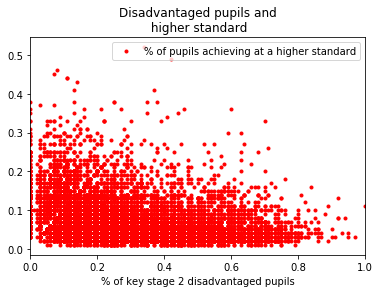

In [41]:
# higher standard
x = '% of key stage 2 disadvantaged pupils'
y = '% of pupils achieving at a higher standard'

# plot schools as yellow dots
df_disadvantage.plot(x=x, y=y, style='r.', title='Disadvantaged pupils and\n higher standard')

As seen in the plot above, there seem to be some correlation between 'Disadvantaged pupils' and 'higher standard', whereas schools with more disadvantaged pupils also seem to have less pupils achieving at a higher standard.

In [42]:
# pearson test: whereas correlation coefficient can range from -1 to +1
scipy.stats.pearsonr(df_disadvantage[x], df_disadvantage[y])[0]# [SA: OK]

-0.28742769508380733